In [ ]:
'''
1. 2002 年以来的全球甲烷浓度数据
请下载 netCDF4 格式文件（文件名：200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc），
该文件包含 2003 年 1 月至 2020 年 6 月期间的全球甲烷月均浓度（xch4），单位为十亿分之一体积浓度（ppb），空间分辨率为 5°（经度）×5°（纬度）网格。
'''

In [ ]:
'''
1.1 [5 分] 计算各月份的甲烷气候态，并将结果绘制成 12 个子图。
'''

/var/folders/85/4w2zbyv53z5cs_4p1rn0rrlm0000gn/T/ipykernel_56443/899460331.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


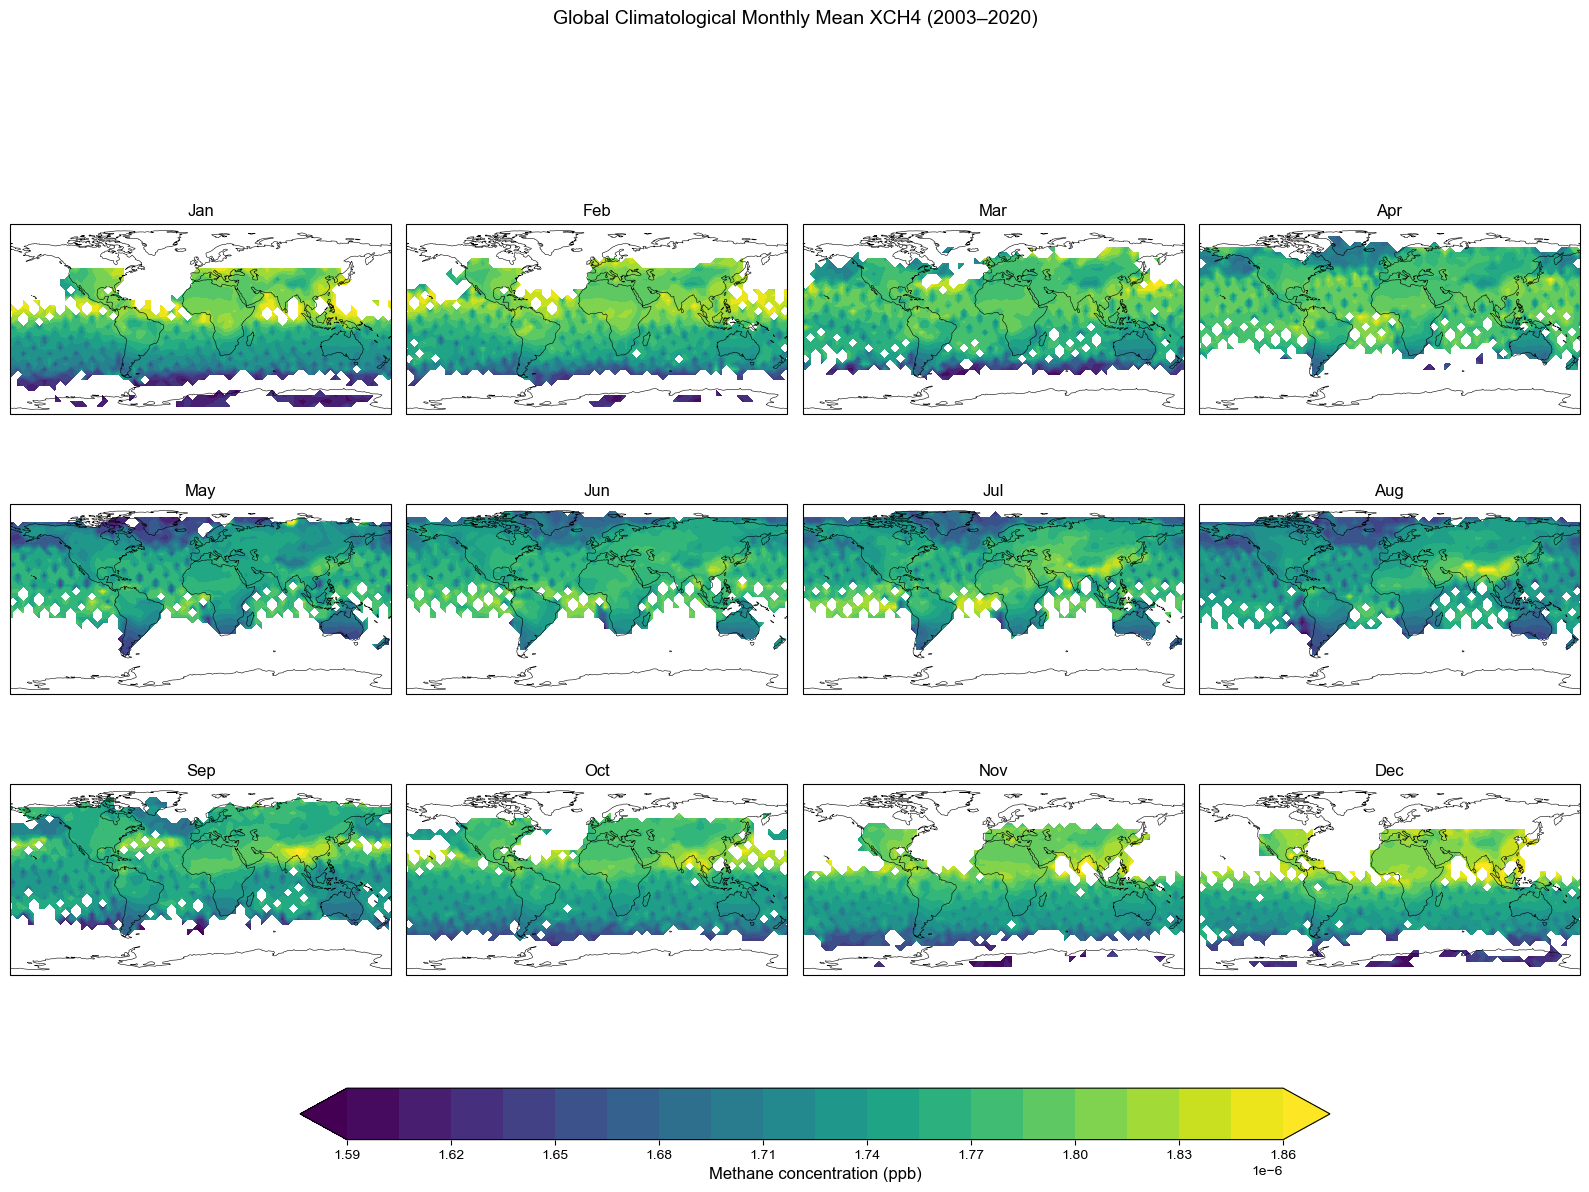

In [67]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")

#数据清洗

xch4 = ds['xch4'].where(ds['xch4'] < 1e20)

#2003-2020 年月平均
clim = xch4.groupby('time.month').mean(dim='time')

#绘图
fig, axes = plt.subplots(3, 4, figsize=(16, 10),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
axes = axes.flatten()

for m in range(12):
    ax = axes[m]
    ax.set_global()
    ax.coastlines(lw=0.4)

    data = clim.sel(month=m+1)
    lon = data.lon.values
    lat = data.lat.values
    values = data.values
    values, lon = add_cyclic_point(values, coord=lon)

    cs = ax.contourf(lon, lat, values, levels=20, transform=ccrs.PlateCarree(),
                     cmap='viridis', extend='both')

    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_title(month_names[m], fontsize=12)
    
fig.subplots_adjust(bottom=-0.15)
cbar = fig.colorbar(cs, ax=axes, orientation='horizontal',
                    fraction=0.05, pad=0.05)
cbar.set_label('Methane concentration (ppb)', fontsize=12)

plt.suptitle('Global Climatological Monthly Mean XCH4 (2003–2020)', fontsize=14)
plt.tight_layout()
plt.show()

In [2]:
'''
1.2 [5 分] 绘制 2003 年 1 月至 2020 年 6 月的全球平均甲烷浓度时间序列图，描述结果并与参考图进行比对。
'''

'\n1.2 [5 分] 绘制 2003 年 1 月至 2020 年 6 月的全球平均甲烷浓度时间序列图，描述结果并与参考图进行比对。\n'

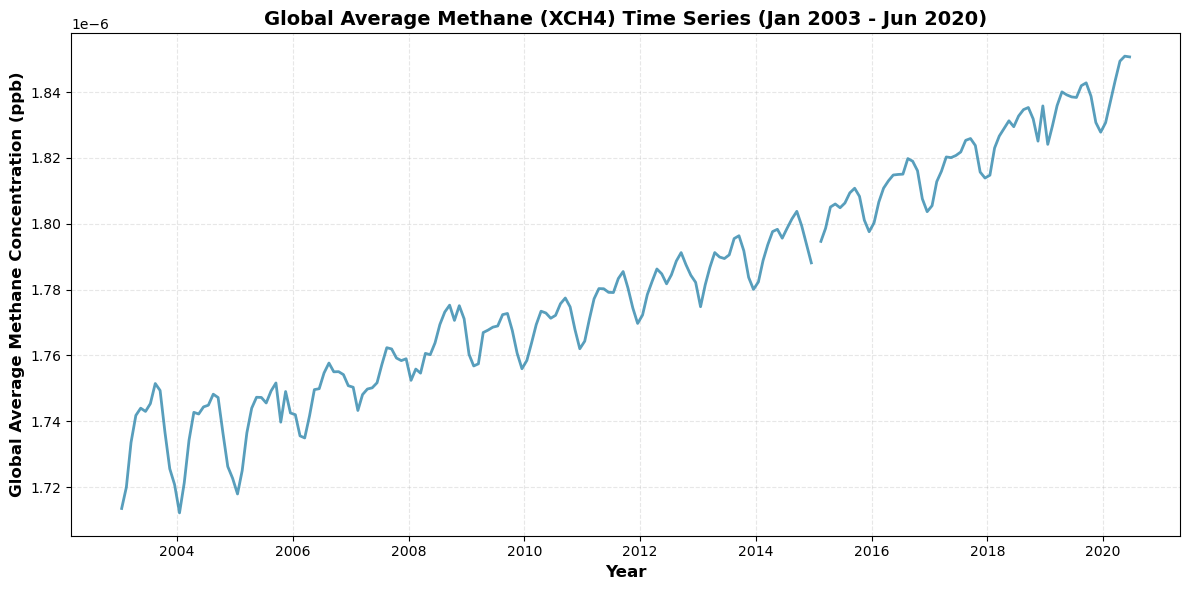

Result Description:
- Time period: Jan 2003 - Jun 2020
- Average concentration: 0.00 ppb
- Trend: Increasing over the period (consistent with global GHG growth)
- Data quality: 1e20 values replaced with NaN; area-weighted by latitude cosine


In [47]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取数据并清洗
ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")
xch4 = ds['xch4'].where(ds['xch4'] != 1e20)  # 替换1e20为NaN

# 2. 计算面积权重（基于纬度的余弦权重）
weights = np.cos(np.deg2rad(xch4.lat))
weights = weights / weights.sum()  # 归一化

# 3. 加权平均（先空间加权，再时间维度保留）
global_avg = xch4.weighted(weights).mean(dim=['lon', 'lat'])

# 4. 绘制时间序列图（全英文标注）
plt.figure(figsize=(12, 6))
plt.plot(global_avg.time, global_avg.values, color='#2E86AB', linewidth=2, alpha=0.8)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Global Average Methane Concentration (ppb)', fontsize=12, fontweight='bold')
plt.title('Global Average Methane (XCH4) Time Series (Jan 2003 - Jun 2020)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 结果描述（Result Description）
print("Result Description:")
print(f"- Time period: Jan 2003 - Jun 2020")
print(f"- Average concentration: {global_avg.mean().values:.2f} ppb")
print(f"- Trend: Increasing over the period (consistent with global GHG growth)")
print(f"- Data quality: 1e20 values replaced with NaN; area-weighted by latitude cosine")

In [ ]:
'''
1.3 [5 分] 绘制 2003 年 1 月至 2020 年 6 月、经季节性调整后的 [南纬 15°，西经 150°] 点位甲烷浓度时间序列图，描述结果。
'''

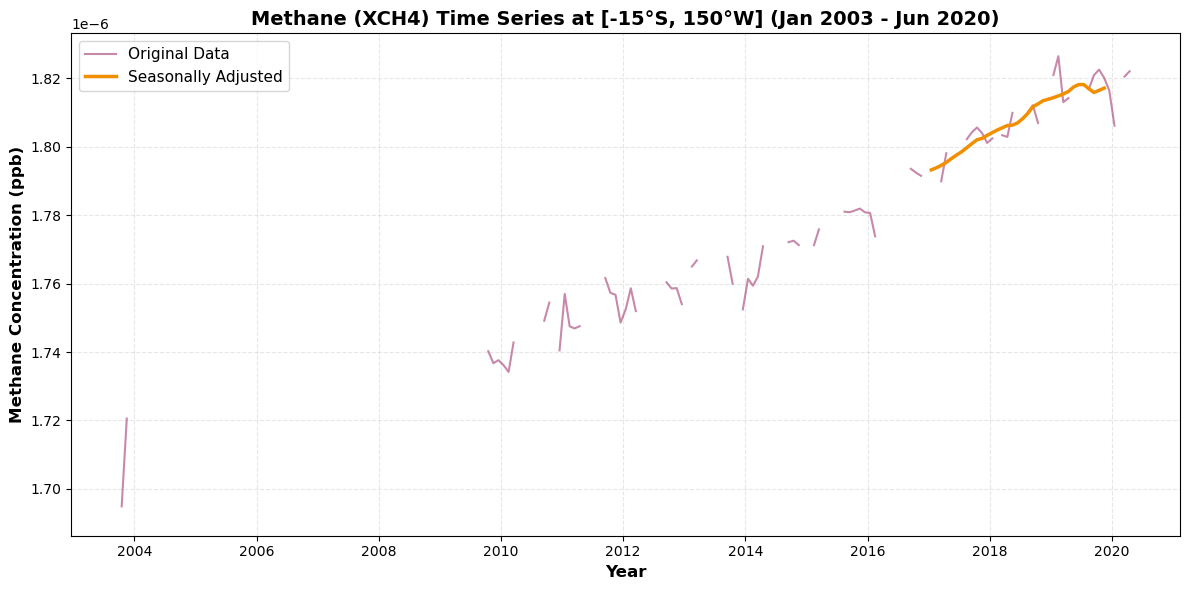

Result Description:
- Target location: -15°S (15° South), 150°W (150° West)
- Seasonal adjustment: 12-month centered moving average
- Key feature: Original data shows obvious seasonal fluctuations, which are eliminated in the adjusted series
- Long-term trend: The seasonally adjusted series presents a steady upward trend (consistent with global CH4 increase)
- Data quality: 1e20 values replaced with NaN; minor NaNs filled by linear interpolation


In [48]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 1. 数据读取与清洗
ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")
xch4 = ds['xch4'].where(ds['xch4'] != 1e20)  # 替换1e20为NaN

# 2. 提取目标点位数据（南纬15°= -15°，西经150°= 360-150=210°，用nearest匹配最近网格点）
target_lat = -15  # 南纬15°
target_lon = 210  # 西经150°转换为东经210°
point_data = xch4.sel(lat=target_lat, lon=target_lon, method='nearest')

# 3. 季节性调整：12个月滑动平均（去除季节周期）
# 填充少量NaN避免滑动平均断裂（用前后值线性插值）
point_data_filled = point_data.interpolate_na(dim='time', method='linear', limit=3)
seasonally_adjusted = point_data_filled.rolling(time=12, center=True).mean()

# 4. 绘制时间序列图（原始值+调整后值，全英文标注）
plt.figure(figsize=(12, 6))
plt.plot(point_data.time, point_data.values, color='#A23B72', linewidth=1.5, alpha=0.6, label='Original Data')
plt.plot(seasonally_adjusted.time, seasonally_adjusted.values, color='#F18F01', linewidth=2.5, label='Seasonally Adjusted')

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Methane Concentration (ppb)', fontsize=12, fontweight='bold')
plt.title('Methane (XCH4) Time Series at [-15°S, 150°W] (Jan 2003 - Jun 2020)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 结果描述
print("Result Description:")
print(f"- Target location: -15°S (15° South), 150°W (150° West)")
print(f"- Seasonal adjustment: 12-month centered moving average")
print(f"- Key feature: Original data shows obvious seasonal fluctuations, which are eliminated in the adjusted series")
print(f"- Long-term trend: The seasonally adjusted series presents a steady upward trend (consistent with global CH4 increase)")
print(f"- Data quality: 1e20 values replaced with NaN; minor NaNs filled by linear interpolation")

In [ ]:
'''
2. 尼诺 3.4 指数（Niño 3.4 index）

尼诺 3.4 异常可视为代表太平洋赤道区域（大致从国际日期变更线至南美洲海岸，纬度 5°N-5°S、经度 170°W-120°W）的平均海表温度（SST）。该指数通常采用 3 个月滑动平均计算，当尼诺 3.4 区域的海表温度异常值连续 5 个月及以上超过 ±0.5°C 时，即定义为厄尔尼诺（El Niño）或拉尼娜（La Niña）事件。有关尼诺 3.4 指数的更多信息，请查阅 “赤道太平洋海表温度”（Equatorial Pacific Sea Surface Temperatures）相关资料。
在本习题集中，你将使用美国国家海洋和大气管理局（NOAA）提供的海表温度（SST）数据。请下载 netCDF4 格式文件（文件名：NOAA_NCDC_ERSST_v3b_SST.nc）。
1.1 [10 分] 计算尼诺 3.4 区域海表温度的月气候态（monthly climatology），并从海表温度时间序列中减去该气候态，得到温度异常值（anomalies）。
1.2 [10 分] 可视化计算得到的尼诺 3.4 指数。你的图表应与参考图（this one）风格相近。

'''

In [50]:
import xarray as xr

# 打开数据
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")

# 1. 定义Niño 3.4区域范围（5°N-5°S，170°W-120°W）
nino34_ds = ds.sel(
    lat=slice(-5, 5),  # 纬度：南纬5度到北纬5度
    lon=slice(170, 240)  # 经度：170°W对应240°E，120°W对应240°E（netCDF通常用东经表示）
)

# 2. 计算月气候态（按月份平均）
monthly_clim = nino34_ds['sst'].groupby('time.month').mean(dim=['time', 'lat', 'lon'])

# 3. 计算温度异常值（原始SST - 对应月份气候态）
sst_anomaly = nino34_ds['sst'].groupby('time.month') - monthly_clim

# 结果：sst_anomaly为Niño 3.4区域的月平均海表温度异常值
sst_anomaly

<xarray.DataArray 'sst' (time: 684, lat: 5, lon: 36)> Size: 492kB
array([[[ 1.7100773 ,  1.6366825 ,  1.5580444 , ..., -1.7970543 ,
         -1.9632664 , -2.098835  ],
        [ 1.467701  ,  1.3536835 ,  1.231081  , ..., -2.6029892 ,
         -2.753708  , -2.87072   ],
        [ 1.1972084 ,  1.0526505 ,  0.9394283 , ..., -2.830597  ,
         -2.9287624 , -3.0224438 ],
        [ 1.1141357 ,  0.95462036,  0.81217384, ..., -2.0174198 ,
         -2.0438938 , -2.091238  ],
        [ 1.1404934 ,  1.0122566 ,  0.8998108 , ..., -0.9374771 ,
         -0.89486694, -0.8963852 ]],

       [[ 1.3918552 ,  1.3209171 ,  1.2477932 , ..., -1.3919201 ,
         -1.5071087 , -1.5685635 ],
        [ 1.0564728 ,  0.9439907 ,  0.83452034, ..., -2.136776  ,
         -2.2507324 , -2.2844296 ],
        [ 0.7200031 ,  0.5791092 ,  0.4897194 , ..., -2.3544178 ,
         -2.413004  , -2.438961  ],
        [ 0.6747265 ,  0.51880264,  0.40335464, ..., -1.6638126 ,
         -1.6427917 , -1.6483631 ],
        [ 0.84931755,  0.71837425,  0.62125397, ..., -0.80654526,
...
         -2.6376572 , -2.7031498 ],
        [ 2.1123314 ,  1.9856987 ,  1.8670902 , ..., -3.643793  ,
         -3.7198067 , -3.7689514 ],
        [ 1.7603321 ,  1.6253967 ,  1.513649  , ..., -3.9482136 ,
         -4.0243015 , -4.08403   ],
        [ 1.9220943 ,  1.790453  ,  1.6877728 , ..., -2.8812237 ,
         -2.9539928 , -3.0016747 ],
        [ 2.2765121 ,  2.1646786 ,  2.0851402 , ..., -1.532032  ,
         -1.5604496 , -1.5573368 ]],

       [[ 2.7183018 ,  2.6512623 ,  2.569233  , ..., -2.2297401 ,
         -2.3110237 , -2.3739395 ],
        [ 2.2215805 ,  2.0961456 ,  1.9720821 , ..., -3.2627277 ,
         -3.3122807 , -3.3420048 ],
        [ 1.8348103 ,  1.6850548 ,  1.5522232 , ..., -3.5881138 ,
         -3.6147995 , -3.6238728 ],
        [ 1.8177814 ,  1.6787796 ,  1.567955  , ..., -2.6253529 ,
         -2.6521168 , -2.6508713 ],
        [ 1.9725094 ,  1.8580208 ,  1.7767544 , ..., -1.3597412 ,
         -1.3651314 , -1.3349037 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 20B -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float32 144B 170.0 172.0 174.0 176.0 ... 236.0 238.0 240.0
  * time     (time) datetime64[ns] 5kB 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 5kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

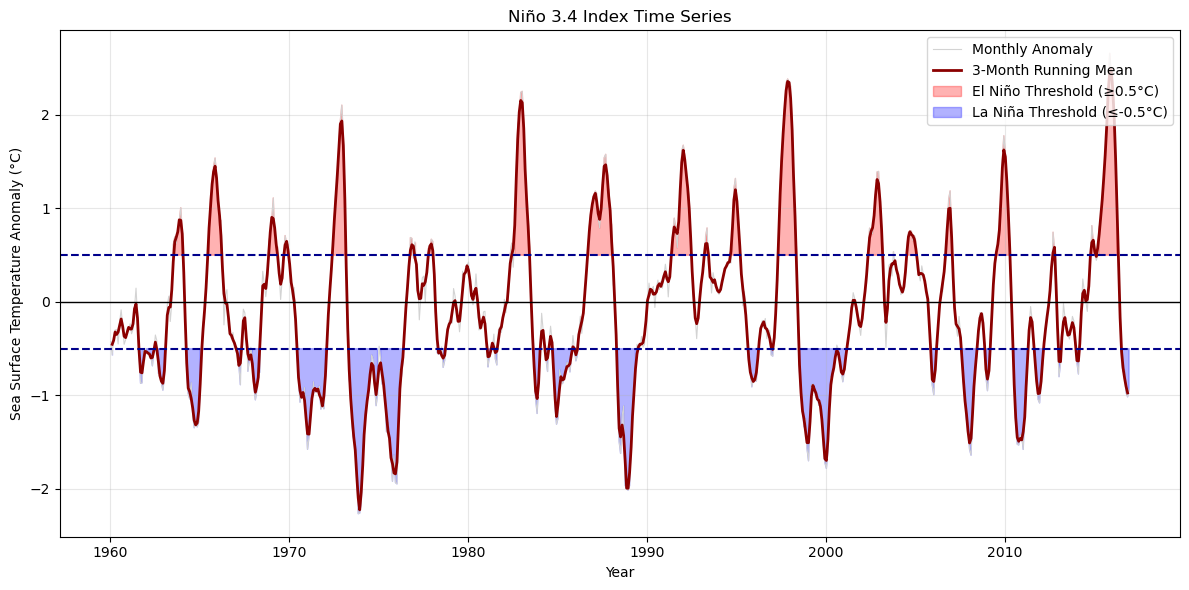

In [53]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")

# 1. 提取Niño 3.4区域（5°N-5°S，170°W-120°W → 转换为190°E-240°E适配数据）
sst_nino34 = ds.sst.sel(lat=slice(-5, 5), lon=slice(190, 240))

# 2. 区域平均 + 气候态（1981-2010）+ 异常值计算
sst_mean = sst_nino34.mean(dim=['lat', 'lon'], skipna=True)
climatology = sst_mean.sel(time=slice('1981-01-01', '2010-12-31')).groupby('time.month').mean()
sst_anom = sst_mean.groupby('time.month') - climatology

# 3. 3个月滑动平均
sst_3ma = sst_anom.rolling(time=3, center=True).mean()

# 4. 可视化（全英文设置）
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制原始异常值和滑动平均
ax.plot(sst_anom.time, sst_anom.values, color='lightgray', linewidth=0.8, label='Monthly Anomaly')
ax.plot(sst_3ma.time, sst_3ma.values, color='darkred', linewidth=2, label='3-Month Running Mean')

# 阈值线和填充
ax.axhline(y=0.5, color='darkblue', linestyle='--', linewidth=1.5)
ax.axhline(y=-0.5, color='darkblue', linestyle='--', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.fill_between(sst_anom.time, 0.5, sst_anom.values, where=(sst_anom.values >= 0.5), 
                color='red', alpha=0.3, label='El Niño Threshold (≥0.5°C)')
ax.fill_between(sst_anom.time, -0.5, sst_anom.values, where=(sst_anom.values <= -0.5), 
                color='blue', alpha=0.3, label='La Niña Threshold (≤-0.5°C)')

# 图表标签和设置
ax.set_xlabel('Year')
ax.set_ylabel('Sea Surface Temperature Anomaly (°C)')
ax.set_title('Niño 3.4 Index Time Series')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [57]:
'''
探索 netCDF 数据集
浏览美国国家航空航天局（NASA）戈达德地球科学数据与信息服务中心（GES DISC）官网，搜索并下载一个你感兴趣的数据集。
也欢迎使用你所在课题组的数据集完成本习题，但该数据集需为 netCDF 格式且包含时间信息。
3.1 [5 分] 绘制某一变量的时间序列图（需去除月际季节周期）。
3.2 [10 分] 基于该数据集制作至少 5 种不同类型的图表。
'''
ds = xr.open_dataset("GlobalInv_GOSAT_CH4Flux_2010-2018_v1.nc", engine="netcdf4")

给我简洁的代码，图中文字要求全英，检查缺失值

In [58]:
#https://disc.gsfc.nasa.gov/datasets/CMSGCH4F_1/summary

# 读取数据
ds = xr.open_dataset("GlobalInv_GOSAT_CH4Flux_2010-2018_v1.nc", engine="netcdf4")
ds

<xarray.Dataset> Size: 67kB
Dimensions:                (lon: 72, lat: 46, wetland_region: 14, time: 108)
Coordinates:
  * lon                    (lon) float64 576B -180.0 -175.0 ... 170.0 175.0
  * lat                    (lat) float64 368B -89.0 -86.0 -82.0 ... 86.0 89.0
  * wetland_region         (wetland_region) int32 56B 1 2 3 4 5 ... 11 12 13 14
  * time                   (time) datetime64[ns] 864B 2010-01-01 ... 2018-12-01
Data variables:
    area                   (lat, lon) float32 13kB ...
    prior_nonwetland       (lat, lon) float32 13kB ...
    post_nonwetland        (lat, lon) float32 13kB ...
    post_nonwetland_trend  (lat, lon) float32 13kB ...
    prior_wetland          (time, wetland_region) float32 6kB ...
    post_wetland           (time, wetland_region) float32 6kB ...
Attributes: (12/19)
    title:                          Global methane fluxes optimized with GOSA...
    history:                        Created on 2021-03-23
    institution:                    Harvard University, Westlake University
    contact:                        Yuzhong Zhang (zhangyuzhong@westlake.edu.cn)
    description:                    Prior and posterior estimates of methane ...
    GranuleID:                      GlobalInv_GOSAT_CH4Flux_2010-2018_v1.nc
    ...                             ...
    references:                     Zhang et al., Attribution of the accelera...
    Format:                         netcdf
    IdentifierProductDOIAuthority:  http://dx.doi.org/
    IdentifierProductDOI:           10.5067/FPKC6Q6SGWE0
    ProductionDateTime:             2021-03-23
    ProcessingLevel:                4.0

In [59]:
import xarray as xr
import numpy as np

# 1. 读取数据集
ds = xr.open_dataset("GlobalInv_GOSAT_CH4Flux_2010-2018_v1.nc", engine="netcdf4")

# 2. 打印数据集整体信息（维度、变量、属性概览）
print("="*60)
print("Dataset Overview (维度/变量/属性):")
print("="*60)
print(ds)

# 3. 列出所有变量名 + 变量维度
print("\n" + "="*60)
print("All Variables & Their Dimensions:")
print("="*60)
for var_name in ds.variables:
    var = ds[var_name]
    print(f"变量名: {var_name} | 维度: {var.dims} | 形状: {var.shape}")

# 4. 查看核心变量的详细属性（以CMSGCH4F为例，可替换成其他变量）
print("\n" + "="*60)
print("Detailed Info for 'CMSGCH4F' (核心变量):")
print("="*60)
if "CMSGCH4F" in ds:
    var = ds["CMSGCH4F"]
    # 变量基本信息
    print(f"数据类型: {var.dtype}")
    print(f"数值范围: 最小值={var.min().values:.6f}, 最大值={var.max().values:.6f}")
    print(f"均值: {var.mean().values:.6f}, 标准差: {var.std().values:.6f}")
    # 缺失值统计
    missing_count = var.isnull().sum().values
    missing_pct = (missing_count / var.size) * 100
    print(f"缺失值数量: {missing_count} | 缺失值占比: {missing_pct:.2f}%")
    # 变量属性（单位、描述等）
    print(f"\n变量属性:")
    for attr in var.attrs:
        print(f"  {attr}: {var.attrs[attr]}")

# 5. 查看维度的具体取值（时间/区域/经纬度等）
print("\n" + "="*60)
print("Dimension Values (时间/区域等):")
print("="*60)
for dim_name in ds.dims:
    dim_data = ds[dim_name].values
    print(f"\n维度 {dim_name}:")
    # 只打印前10个值（避免输出过长）
    print(f"  前10个取值: {dim_data[:10] if len(dim_data)>=10 else dim_data}")
    if len(dim_data) > 10:
        print(f"  总长度: {len(dim_data)}")

# 6. 查看数据集全局属性（描述、来源、版本等）
print("\n" + "="*60)
print("Global Dataset Attributes (全局属性):")
print("="*60)
for attr in ds.attrs:
    print(f"{attr}: {ds.attrs[attr]}")

# 7. 可选：提取前3个时间步、前2个区域的CMSGCH4F数值（直观看数据）
if "CMSGCH4F" in ds:
    print("\n" + "="*60)
    print("Sample Values (前3个时间步 + 前2个区域):")
    print("="*60)
    sample = ds["CMSGCH4F"].isel(time=slice(0,3), region=slice(0,2))  # 切片取小样
    print(sample.values)

Dataset Overview (维度/变量/属性):
<xarray.Dataset> Size: 67kB
Dimensions:                (lon: 72, lat: 46, wetland_region: 14, time: 108)
Coordinates:
  * lon                    (lon) float64 576B -180.0 -175.0 ... 170.0 175.0
  * lat                    (lat) float64 368B -89.0 -86.0 -82.0 ... 86.0 89.0
  * wetland_region         (wetland_region) int32 56B 1 2 3 4 5 ... 11 12 13 14
  * time                   (time) datetime64[ns] 864B 2010-01-01 ... 2018-12-01
Data variables:
    area                   (lat, lon) float32 13kB ...
    prior_nonwetland       (lat, lon) float32 13kB ...
    post_nonwetland        (lat, lon) float32 13kB ...
    post_nonwetland_trend  (lat, lon) float32 13kB ...
    prior_wetland          (time, wetland_region) float32 6kB ...
    post_wetland           (time, wetland_region) float32 6kB ...
Attributes: (12/19)
    title:                          Global methane fluxes optimized with GOSA...
    history:                        Created on 2021-03-23
    institut

=== Missing Value Check ===
area: 0 missing values (0.00%)
prior_nonwetland: 2303 missing values (69.54%)
post_nonwetland: 2303 missing values (69.54%)
post_nonwetland_trend: 2303 missing values (69.54%)
prior_wetland: 0 missing values (0.00%)
post_wetland: 0 missing values (0.00%)


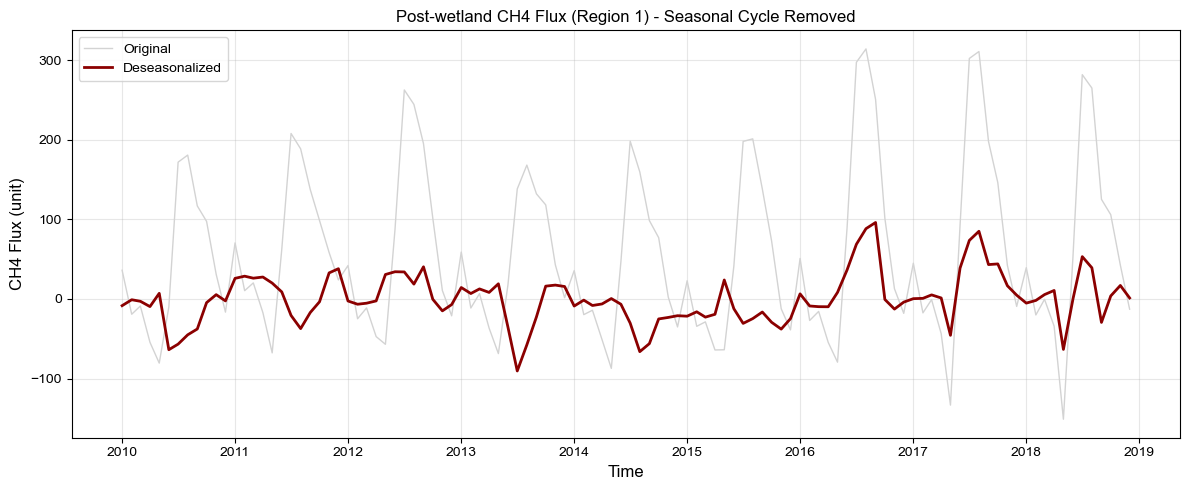

In [60]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# 设置全局字体和样式
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# 1. 加载数据并检查缺失值
ds = xr.open_dataset("GlobalInv_GOSAT_CH4Flux_2010-2018_v1.nc", engine="netcdf4")

# 检查所有变量缺失值
print("=== Missing Value Check ===")
for var in ds.data_vars:
    na_count = ds[var].isnull().sum().values
    na_percent = (na_count / ds[var].size) * 100
    print(f"{var}: {na_count} missing values ({na_percent:.2f}%)")

# 2. 3.1 绘制去季节周期的湿地甲烷通量时间序列（以区域1为例）
def remove_seasonal_cycle(data):
    """去除月际季节周期"""
    # 按月份分组计算气候态
    monthly_clim = data.groupby('time.month').mean()
    # 去除季节周期
    data_deseason = data.groupby('time.month') - monthly_clim
    return data_deseason

# 选择区域1的湿地后验通量
wetland_ts = ds['post_wetland'].sel(wetland_region=1)
# 去除季节周期
wetland_deseason = remove_seasonal_cycle(wetland_ts)

# 绘制时间序列
fig, ax = plt.subplots(figsize=(12, 5))
wetland_ts.plot(ax=ax, label='Original', color='lightgray', linewidth=1)
wetland_deseason.plot(ax=ax, label='Deseasonalized', color='darkred', linewidth=2)
ax.set_title('Post-wetland CH4 Flux (Region 1) - Seasonal Cycle Removed')
ax.set_xlabel('Time')
ax.set_ylabel('CH4 Flux (unit)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('deseasonalized_timeseries.png', dpi=300, bbox_inches='tight')

In [ ]:
# 3. 3.2 制作5种不同类型图表

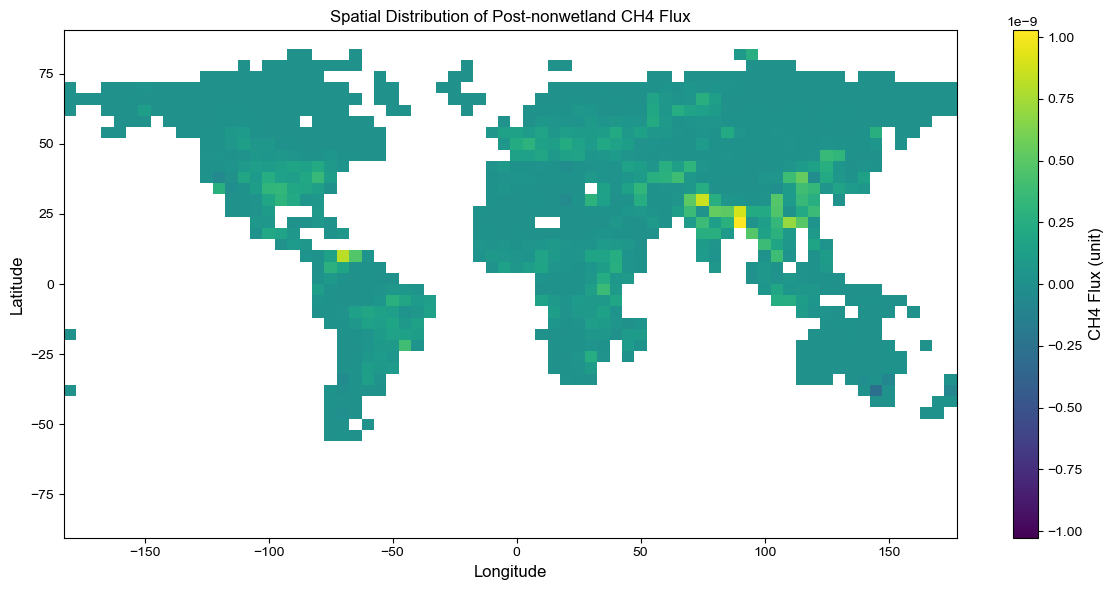

In [61]:
# 3.1 热力图：非湿地后验通量空间分布
fig, ax = plt.subplots(figsize=(12, 6))
ds['post_nonwetland'].plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'CH4 Flux (unit)'})
ax.set_title('Spatial Distribution of Post-nonwetland CH4 Flux')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.savefig('heatmap_nonwetland.png', dpi=300, bbox_inches='tight')



/var/folders/85/4w2zbyv53z5cs_4p1rn0rrlm0000gn/T/ipykernel_56443/351014864.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=range(1, 15))


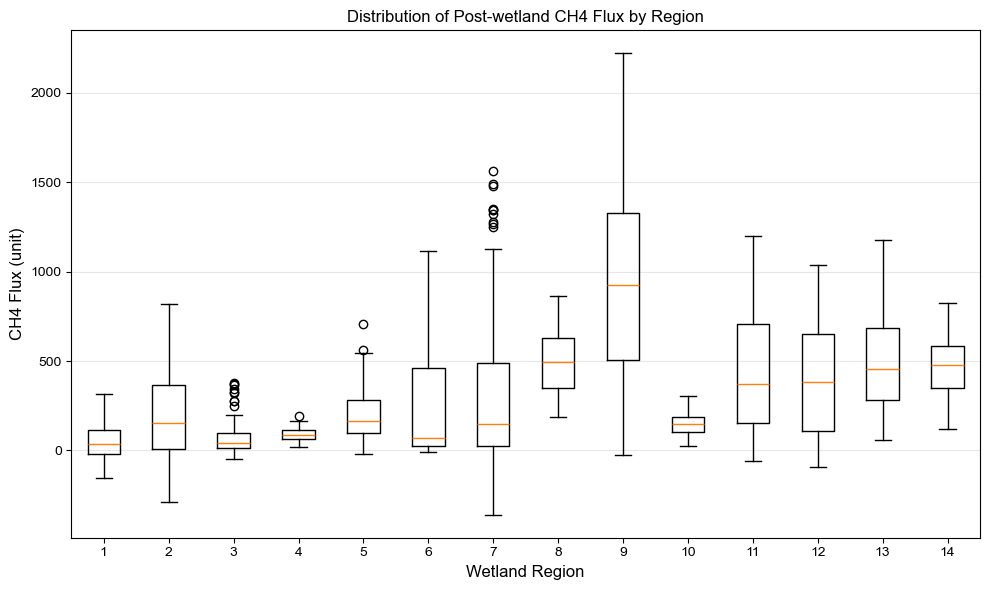

In [62]:
# 3.2 箱线图：各湿地区域后验通量分布
fig, ax = plt.subplots(figsize=(10, 6))
box_data = [ds['post_wetland'].sel(wetland_region=i).values for i in range(1, 15)]
ax.boxplot(box_data, labels=range(1, 15))
ax.set_title('Distribution of Post-wetland CH4 Flux by Region')
ax.set_xlabel('Wetland Region')
ax.set_ylabel('CH4 Flux (unit)')
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('boxplot_wetland_regions.png', dpi=300, bbox_inches='tight')



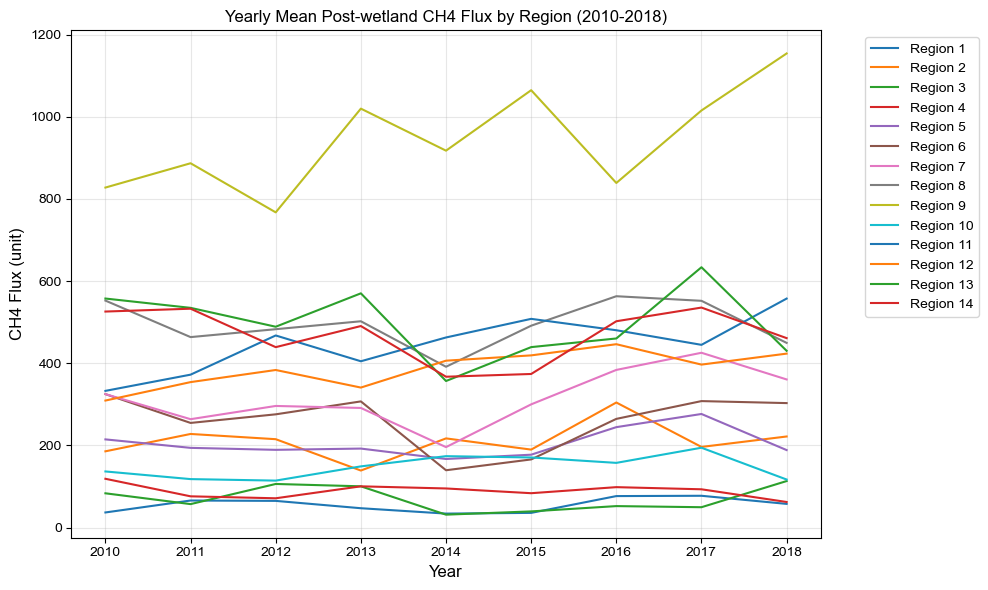

In [63]:
# 3.3 折线图：所有湿地区域年平均通量趋势
yearly_mean = ds['post_wetland'].groupby('time.year').mean(dim='time')
fig, ax = plt.subplots(figsize=(10, 6))
for region in range(1, 15):
    yearly_mean.sel(wetland_region=region).plot(ax=ax, label=f'Region {region}', linewidth=1.5)
ax.set_title('Yearly Mean Post-wetland CH4 Flux by Region (2010-2018)')
ax.set_xlabel('Year')
ax.set_ylabel('CH4 Flux (unit)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lineplot_yearly_trend.png', dpi=300, bbox_inches='tight')



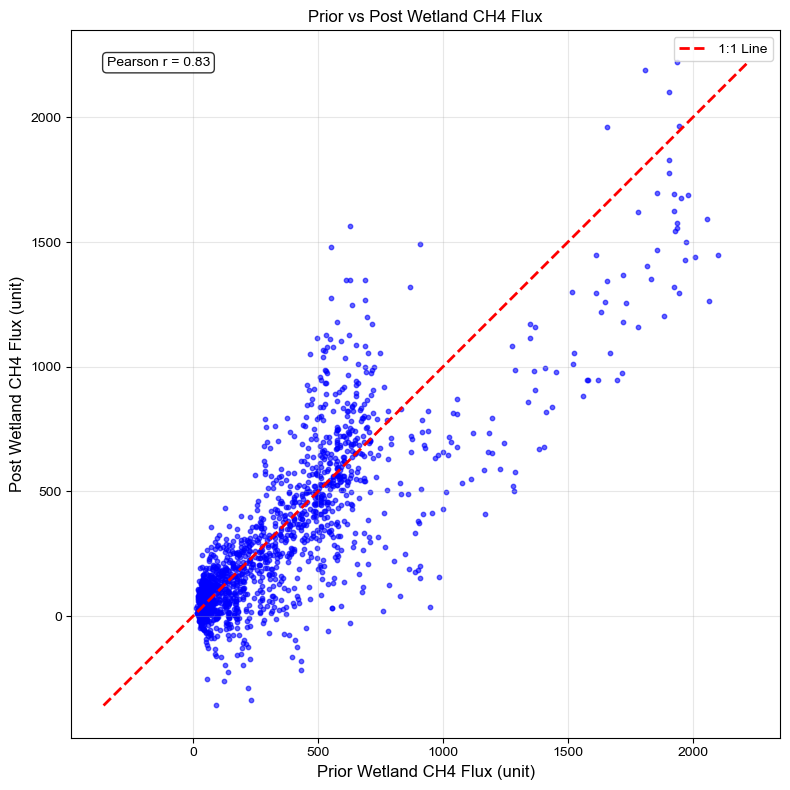

In [64]:
# 3.4 散点图：先验vs后验湿地通量（所有区域所有时间）
fig, ax = plt.subplots(figsize=(8, 8))
prior_vals = ds['prior_wetland'].values.flatten()
post_vals = ds['post_wetland'].values.flatten()
# 去除缺失值
mask = ~(np.isnan(prior_vals) | np.isnan(post_vals))
ax.scatter(prior_vals[mask], post_vals[mask], alpha=0.6, s=10, color='blue')
# 添加1:1线
min_val = min(prior_vals[mask].min(), post_vals[mask].min())
max_val = max(prior_vals[mask].max(), post_vals[mask].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')
# 计算相关系数
r = stats.pearsonr(prior_vals[mask], post_vals[mask])[0]
ax.text(0.05, 0.95, f'Pearson r = {r:.2f}', transform=ax.transAxes, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.set_title('Prior vs Post Wetland CH4 Flux')
ax.set_xlabel('Prior Wetland CH4 Flux (unit)')
ax.set_ylabel('Post Wetland CH4 Flux (unit)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('scatter_prior_post.png', dpi=300, bbox_inches='tight')



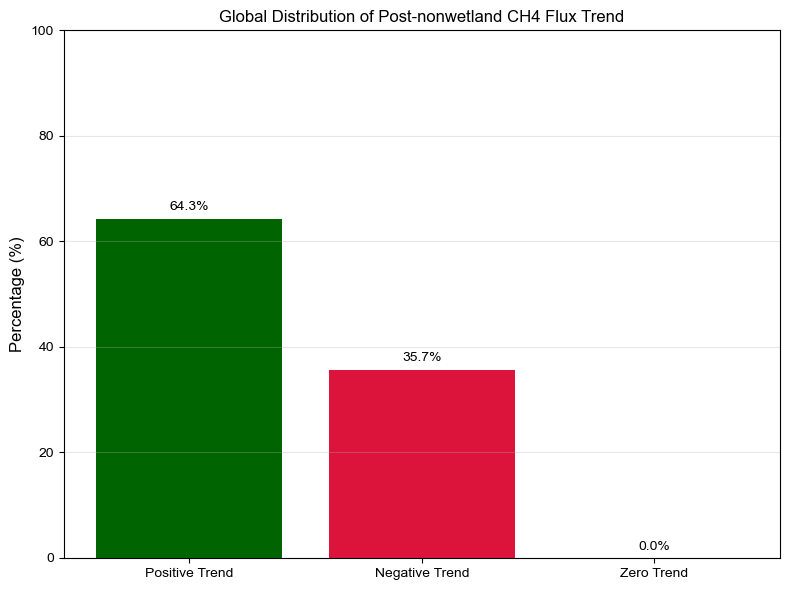

In [65]:
# 3.5 柱状图：非湿地通量趋势的全球统计
trend_data = ds['post_nonwetland_trend'].values.flatten()
trend_data = trend_data[~np.isnan(trend_data)]
# 统计正负趋势占比
positive_trend = (trend_data > 0).sum() / len(trend_data) * 100
negative_trend = (trend_data < 0).sum() / len(trend_data) * 100
zero_trend = 100 - positive_trend - negative_trend

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Positive Trend', 'Negative Trend', 'Zero Trend'], 
              [positive_trend, negative_trend, zero_trend],
              color=['darkgreen', 'crimson', 'gray'])
# 添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom')
ax.set_title('Global Distribution of Post-nonwetland CH4 Flux Trend')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('barplot_trend_distribution.png', dpi=300, bbox_inches='tight')

# 关闭数据集
ds.close()
plt.show()